In [91]:
# from tensorflow.keras.appliications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC,Precision,Recall
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,Tensorboard

from tensorflow.keras.mixed_precision import set_global_policy
import numpy as np
import os

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

In [67]:
# # https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
# base_model = EfficientNetB0(include_top=False,weights = 'imagenet')

# inputs = layers.Input(shape=(224,224,1))
# x = layers.Conv2D(3,(3,3), padding = 'same')(inputs)
# x = base_model(x)
# x = layers.GlobalAveragePooling2D()(x)
# outputs = layers.Dense(8,activation='sigmoid')(x)

# model = models.Model(inputs,outputs)
# model.summary()

In [ ]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Use mixed precision
# https://keras.io/api/mixed_precision/
set_global_policy('mixed_float16')

# Clear GPU memory
tf.keras.backend.clear_session()


with tf.device('/GPU:0'):
    base_model = EfficientNetB0(include_top=False,weights = 'imagenet')

    inputs = layers.Input(shape=(224,224,1))
    x = layers.Conv2D(3,(3,3), padding = 'same')(inputs)
    # x = layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # base_model.
    outputs = layers.Dense(7,activation='sigmoid')(x)

    # model.add

    model = models.Model(inputs,outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,568 (15.48 MB)

 Trainable params: 4,016,545 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [69]:
model.compile(optimizer="adam",loss="binary_crossentropy", metrics = ["binary_accuracy"
                                                                      # , "val_accuracy"
                                                                    #   ,AUC(), Precision(),Recall()
                                                                      ])


In [70]:
import os
os.path.exists('/home/aifablab/projects/ElijahKun/TestOne/IS_Report/data/numpy/Y_train.npy')


True

In [71]:

# X_train = np.load("../data/numpy/X_train.npy")
# Y_train = np.load("../data/numpy/Y_train.npy")

# X_val = np.load("../data/numpy/X_valid.npy")
# Y_val = np.load("../data/numpy/Y_valid.npy")


X_train = np.load("/home/aifablab/projects/ElijahKun/TestOne/IS_Report/data/numpy/X_train.npy")
Y_train = np.load("/home/aifablab/projects/ElijahKun/TestOne/IS_Report/data/numpy/Y_train.npy")

X_val = np.load("/home/aifablab/projects/ElijahKun/TestOne/IS_Report/data/numpy/X_valid.npy")
Y_val = np.load("/home/aifablab/projects/ElijahKun/TestOne/IS_Report/data/numpy/Y_valid.npy")



In [72]:
print(X_train[0].shape)
print(Y_train.shape)

(224, 224, 1)
(12589, 7)


In [93]:
my_callbacks = [
    ModelCheckpoint(
        monitor = "val_loss" ,# commonly uses valloss why? cuz secret
        verbose =1,
        filepath = "../checkpoint/model_{epoch:02d}.keras",
        save_best_only = True,
        save_weights_only = False
    )
]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(8)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(8)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    # batch_size = 8,
    verbose = 1,
    callbacks = my_callbacks
)


Epoch 1/80
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.9652 - loss: 0.0889
Epoch 1: val_loss improved from inf to 0.70486, saving model to ../checkpoint/model_01.keras
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - binary_accuracy: 0.9652 - loss: 0.0889 - val_binary_accuracy: 0.7987 - val_loss: 0.7049
Epoch 2/80
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.9710 - loss: 0.0761
Epoch 2: val_loss improved from 0.70486 to 0.65522, saving model to ../checkpoint/model_02.keras
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - binary_accuracy: 0.9710 - loss: 0.0761 - val_binary_accuracy: 0.8240 - val_loss: 0.6552
Epoch 3/80
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.9740 - loss: 0.0676
Epoch 3: val_loss did not improve from 0.65522
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - binary_accuracy: 0.9740 - loss: 0.0676 - val_binary_accuracy: 0.6393 - val_loss: 0.9114
Epoch 4/80
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accura

KeyboardInterrupt: 

In [74]:
# history = model.fit(
#     train_ds,
#     validation_data = (X_val, Y_val),
#     epochs = 10,
#     batch_size = 8,
#     verbose = 1
#     )

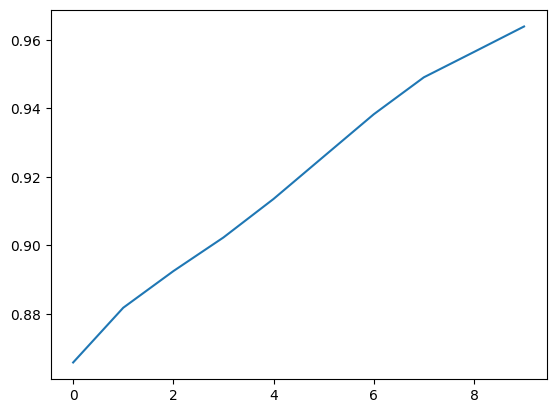

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["binary_accuracy"])
# plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
X_test = np.load("../data/numpy/X_test.npy")
Y_test = np.load("../data/numpy/Y_test.npy")
results = model.evaluate(X_test,Y_test,batch_size=10)



2025-04-29 13:34:30.533431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2044', 120 bytes spill stores, 120 bytes spill loads

2025-04-29 13:34:30.791163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2044', 1672 bytes spill stores, 1640 bytes spill loads



70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8059 - loss: 0.4465

2025-04-29 13:34:42.049199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2044', 120 bytes spill stores, 120 bytes spill loads

2025-04-29 13:34:42.261240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2044', 1484 bytes spill stores, 1484 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - binary_accuracy: 0.8057 - loss: 0.4465


In [ ]:
# predictions = model.predict(X_test[:3])
# print(predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(3, 7)


In [94]:
models.load_model("../checkpoint/model_02.keras")
print(len(model.layers))
# for layer in models.layer[:]:


5
